<a href="https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/notebooks/cell_fitness/Exercise_1_Exploration_of_Prism_Pr500_Cell_Viability_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Prism Cell Viability Data

In [4]:
# Install dependencies
# install cmapPy
!pip -q install cmapPy
# download workshop data
!wget --quiet -O - https://s3.amazonaws.com/repo-assets.clue.io/lincswkshp20_pfc_assets.tgz|tar zx -C .

import warnings
warnings.filterwarnings("ignore")
import os.path
import pandas as pd
from cmapPy.pandasGEXpress import parse as pe
import cmapPy.pandasGEXpress.GCToo as GCToo
import cmapPy.pandasGEXpress.write_gctx as wgx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import functools
import string
import matplotlib
# print Pandas df as formatted tables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Plotting defaults
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
matplotlib.rcParams['figure.figsize'] = [8, 6]

     |████████████████████████████████| 153kB 5.1MB/s 


### Dataset Description

**PRISM Experiment**: 489 cell lines treated with 120 small molecule compounds at 3-point concentration for 120 hours in triplicate

**Data Pre-Processing and signature generation**:
Raw Data were processed using Merino pipeline. Differential viability scores were computed using log-fold change with respect to all treatments in the plate. Replicate treatments were collapsed using a correlation weighted averaging procedure (MODZ) to yield the signatures


In [ ]:
BASE_PATH = './assets'
gct = pe.parse(os.path.join(BASE_PATH, 'PASG003_LEVEL5_MODZ.LFCPC.COMBAT_n383x489.gctx'))
signature_info = pd.read_table(os.path.join(BASE_PATH, 'PASG003_sig_metrics_MODZ.LFCPC.COMBAT.txt'), index_col='sig_id')
cell_info = pd.read_table(os.path.join(BASE_PATH, 'PRISM-Pr500_cell_info.txt'))

PRISM is an assay with 500 cell lines - let's take a look at their contents

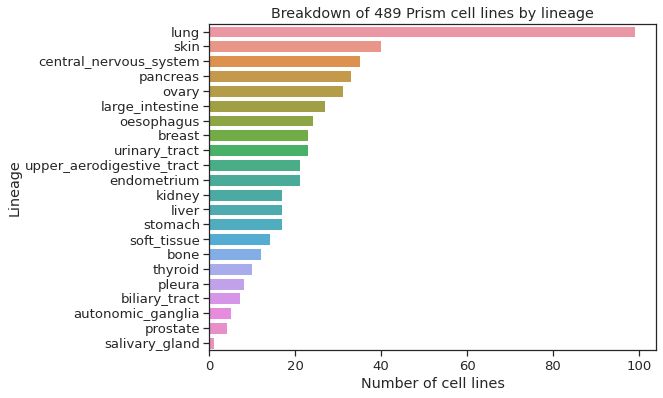

In [ ]:
# ignore control barcodes
cell_info_filt = cell_info[cell_info['cell_lineage']!= '-666']
lineage_counts = cell_info_filt['cell_lineage'].value_counts().reset_index()
lineage_counts.columns = ['Cell Lineage', 'count']

fg = sns.barplot(y='Cell Lineage', x='count', data=lineage_counts)
_ = fg.set(xlabel='Number of cell lines', ylabel='Lineage', title='Breakdown of {0} Prism cell lines by lineage'.format(cell_info_filt.shape[0]))
plt.show()


First let's just look at the distribution of the data.

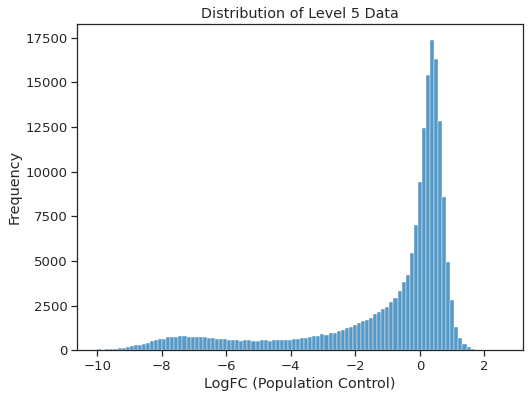

In [ ]:
fg = sns.histplot(x=gct.data_df.unstack(), bins=100)
_ = fg.set(xlabel='LogFC (Population Control)', ylabel='Frequency', title='Distribution of Level 5 Data')
plt.show()

The data is centered around 0 but has a long negative tail, all the way to our cutoff of -10. This is what we expect, given that most drugs will not kill most cell lines. 

On it's own this doesn't tell us much. Next we will map out the strength of individual signatures with an SC plot. 

SC plots are simply a scatter of a signatures strength vs its reproducibility. Its strength is defined as the number of cell lines which had a z-score below a certain threshold (in this case -2), and reproducibility is the Q75 of the correlation between three replicates.

Text(0.5, 1.0, 'Mean vs Variance for PRISM Lines')

Text(0.5, 0, 'Mean')

Text(0, 0.5, 'Variance')

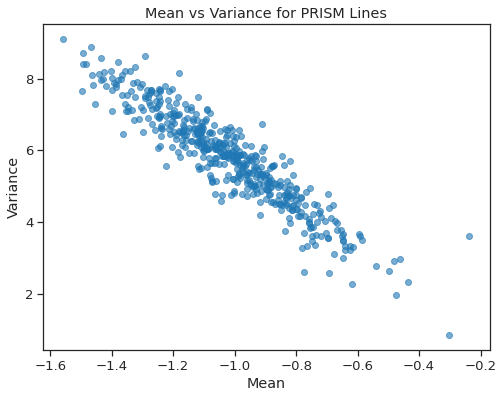

Text(0.5, 1.0, 'Distribution of Hit Rate Per Line in PRISM 500')

Text(0.5, 0, '"Hits" Called Across 384 Signatures Per Cell Line')

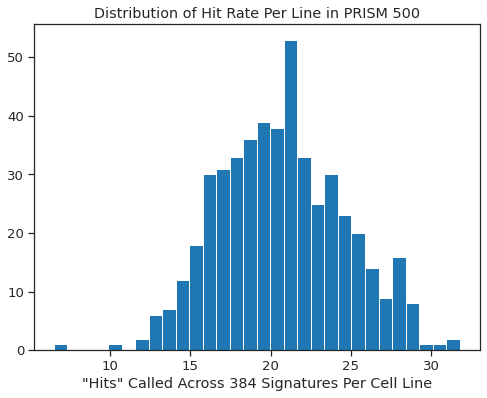

In [ ]:
plt.scatter(gct.data_df.mean(axis=1), gct.data_df.var(axis=1), alpha=0.6)
plt.title('Mean vs Variance for PRISM Lines')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.show()

n,b,p = plt.hist((gct.data_df[gct.data_df < -2].count(axis=1) / 3.84), 30)
plt.title('Distribution of Hit Rate Per Line in PRISM 500')
plt.xlabel('"Hits" Called Across 384 Signatures Per Cell Line')
plt.show()

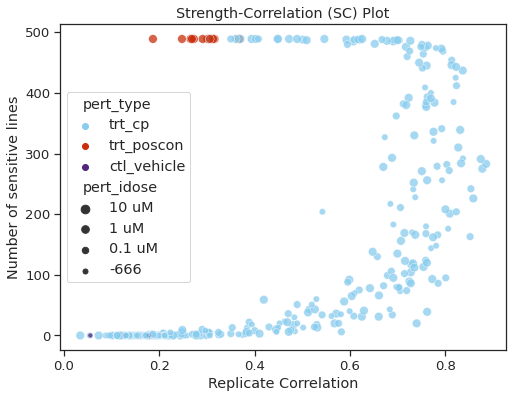

In [ ]:
keep_type = ['trt_cp', 'trt_poscon', 'ctl_vehicle']
type_palette = {'trt_poscon':'#c92d0a', 'ctl_vehicle':'#52267e', 'trt_cp':'#88ccee'}
size_order = ['10 uM', '1 uM', '0.1 uM', '-666']

df = signature_info[signature_info['pert_type'].isin(keep_type)]
fg = sns.scatterplot(x='cc_q75', y='ss_ltn2', size='pert_idose', size_order = size_order, sizes=(25, 75),
                     hue='pert_type', hue_order=keep_type, alpha=0.75, 
                     palette=type_palette, data=df)
_ = fg.set(xlabel='Replicate Correlation', ylabel='Number of sensitive lines', title='Strength-Correlation (SC) Plot')
plt.show()


We've colored the plot by type of compound. Blue dots are DMSO negative controls, red dots are Bortezomib positive controls. And green dots are treatment compounds. As you can see, the controls are well behaved. Bortezomib kills everything and is somewhat highly correlated. DMSO kills nothing and is not well correlated. All of our treatment compounds sit somewhere between those extremes. 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text major ticklabel objects>)

Text(0.5, 1.0, 'Heatmap of CIS Values for PASG')

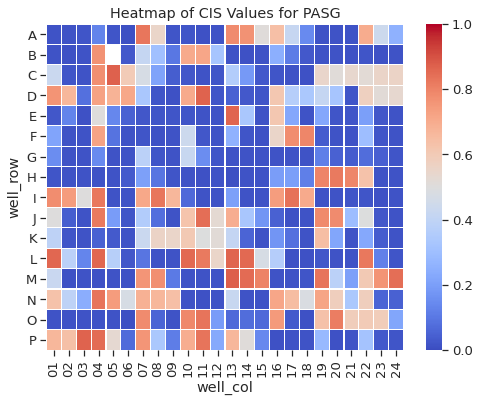

In [ ]:
values = signature_info['cis_ltn2']
signature_info['well_row'] = [x[0] for x in signature_info['pert_well']]
signature_info['well_col'] = [x[1:] for x in signature_info['pert_well']]

heatmap_df = pd.pivot_table(signature_info, values='cis_ltn2', index='well_row', columns='well_col')
sns.heatmap(heatmap_df, linewidths=.1, cmap='coolwarm', vmin=0, vmax=1)

plt.yticks(rotation=1)
plt.title('Heatmap of CIS Values for PASG')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30)
# Transform into array of shape [n_samples, 2]
X_trans = tsne.fit_transform(gct.data_df.T)
X_trans = pd.DataFrame(X_trans)
X_trans.index = signature_info.index
X_trans.columns = ['TS1', 'TS2']

signature_info = signature_info.join(X_trans)

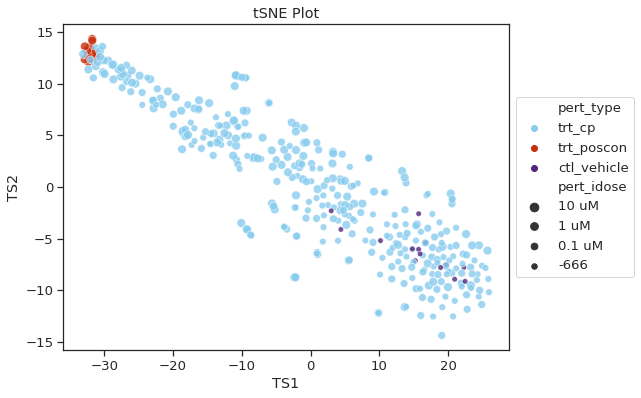

In [ ]:
df = signature_info[signature_info['pert_type'].isin(keep_type)]

fg = sns.scatterplot(x='TS1', y='TS2', 
                     size='pert_idose', size_order = size_order, sizes=(30, 75),
                     hue='pert_type', hue_order=keep_type, alpha=0.8, 
                     palette=type_palette, data=df)
_ = fg.set(xlabel='TS1', ylabel='TS2', title='tSNE Plot')
_ = fg.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()